In [3]:
import numpy as np
# import cupy as cp
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import time
import gc

# Data Generation

In [180]:
n=2
r=4
R=10
n_samples = 1000

In [181]:
center = np.random.randn(2)
print("Center Point: ", center)

Center Point:  [1.30083465 0.46289342]


In [182]:
data_list = []
mag_vec = R*np.ones(n)
n_cluster = np.power(2, n)

In [183]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

In [184]:
sample_list = []

In [185]:
for i in range(n_samples):
    d = np.random.choice(n_cluster,1)[0]
    sample = mag_vec-2*R*bin_array(d,n)+r*np.random.randn(n)
    sample_list.append(sample)

In [186]:
samples_np = np.array(sample_list)

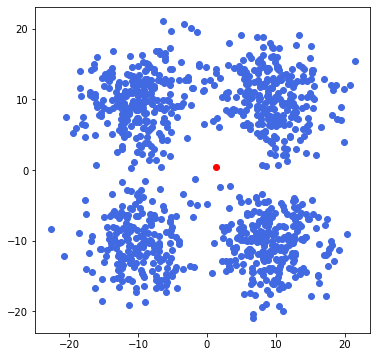

In [187]:
plt.figure(figsize=(6,6))
plt.scatter(center[0], center[1], color='red')
plt.scatter(samples_np[:,0],samples_np[:,1], color='royalblue')

# Prototype Selection

In [53]:
from sklearn.metrics.pairwise import rbf_kernel

In [96]:
import sys

def check_submodularity(K, n):
    K2 = K.copy()
    scale = n**3 + 2*(n**2) - 2*n - 3
    cond1 = np.all(np.diag(K2) == 1)
    cond2 = np.all( np.sum(K2-np.eye(n), axis=1) < 1 )
    cond3 = np.all( (K2-np.eye(n)) < 1/scale )
    return cond1, cond2, cond3

def greedy_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
#     value = np.array([])
    f_list = []
    cond_list = []
    nsk = 0
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        lenS = len(selected)
        if lenS > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(lenS + 1)

            s3array = s1array - s2array

        else:
            if is_K_sparse:
                s3array = s1array - (np.abs(K.diagonal()[candidates]))
            else:
                s3array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        max_idx = np.argmax(s3array)
        if lenS > 0:
            sk = np.sum(K[selected, :][:, selected])
            f = s3array[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            f_list.append(f)
        else:
            f_list.append(s3array[max_idx])
        
        argmax = candidates[max_idx]
        # print("max %f" %np.max(s1array))

        selected = np.append(selected, argmax)
        
        '''nsk: (2/n)*\sum{k([n],S)}'''
        nsk += s1array[max_idx]
        
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        
        '''validity check'''
        cond1, cond2, cond3 = check_submodularity(KK, len(selected))
#         print("%s, %s, %s"%(cond1, cond2, cond3))
        cond_list.append([cond1, cond2, cond3])
        
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected], f_list, cond_list

In [149]:
def greedy_add_protos(K, candidate_indices, m, selected_indices, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    colsum = 2*np.sum(K, axis=0) / n
#     selected = np.array([], dtype=int)
    selected = selected_indices
    m = m-len(selected_indices)

    f_list = []
    cond_list = []
    nsk = np.sum(colsum[selected], axis=0)
    
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        lenS = len(selected)
        if lenS > 0:
            temp = K[selected, :][:, candidates]
            s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]
            s2array = s2array/(lenS + 1)
            s3array = s1array - s2array
        else:
            s3array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        max_idx = np.argmax(s3array)
        if lenS > 0:
            sk = np.sum(K[selected, :][:, selected])
            f = s3array[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            f_list.append(f)
        else:
            f_list.append(s3array[max_idx])
        
        argmax = candidates[max_idx]
        # print("max %f" %np.max(s1array))

        selected = np.append(selected, argmax)
        
        '''nsk: (2/n)*\sum{k([n],S)}'''
        nsk += s1array[max_idx]
        
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        
        '''validity check'''
        cond1, cond2, cond3 = check_submodularity(KK, len(selected))
#         print("%s, %s, %s"%(cond1, cond2, cond3))
        cond_list.append([cond1, cond2, cond3])

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected], f_list, cond_list

In [218]:
%%time
kernel_matrix = rbf_kernel(samples_np, gamma=0.03)

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 30.6 ms


In [219]:
print(kernel_matrix)

[[1.00000000e+00 2.87962445e-03 3.19476440e-01 ... 2.61711489e-13
  9.08439410e-12 4.22134328e-01]
 [2.87962445e-03 1.00000000e+00 1.18176897e-01 ... 1.57589831e-07
  5.22346398e-13 6.06486965e-02]
 [3.19476440e-01 1.18176897e-01 1.00000000e+00 ... 3.40533540e-09
  3.89662729e-10 9.54404125e-01]
 ...
 [2.61711489e-13 1.57589831e-07 3.40533540e-09 ... 1.00000000e+00
  2.23128827e-06 1.86902215e-09]
 [9.08439410e-12 5.22346398e-13 3.89662729e-10 ... 2.23128827e-06
  1.00000000e+00 1.01407031e-09]
 [4.22134328e-01 6.06486965e-02 9.54404125e-01 ... 1.86902215e-09
  1.01407031e-09 1.00000000e+00]]


In [220]:
selected, f_list, _ = greedy_protos(kernel_matrix, np.arange(n_samples), n_cluster)
print(selected)

[843 694 823 475]


In [221]:
# ideal prototypes: 613 997 346 366

In [222]:
protos = samples_np[selected]

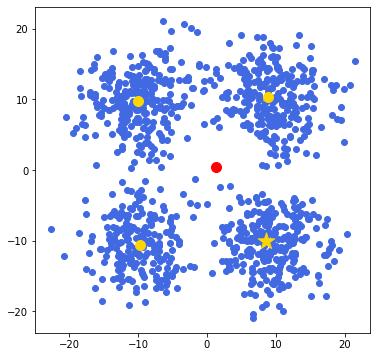

In [223]:
plt.figure(figsize=(6,6))
plt.scatter(center[0], center[1], color='red', s=100)
plt.scatter(samples_np[:,0],samples_np[:,1], color='royalblue')
plt.scatter(protos[0,0], protos[0,1], color='gold', s=300, marker='*')
plt.scatter(protos[1:,0], protos[1:,1], color='gold', s=100)

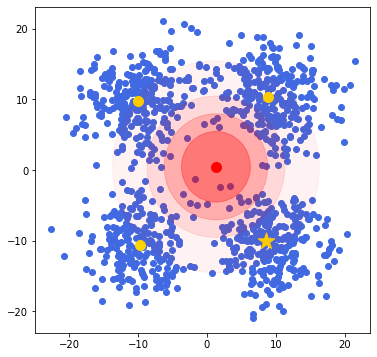

In [224]:
plt.figure(figsize=(6,6))

temp_R = 5
cir1 = plt.Circle(center, temp_R, color='r', alpha=0.3)
cir2 = plt.Circle(center, temp_R*1.5, color='r', alpha=0.2)
cir3 = plt.Circle(center, temp_R*2, color='r', alpha=0.1)
cir4 = plt.Circle(center, temp_R*3, color='r', alpha=0.05)
# ax.add_patch(cir)
plt.gca().add_patch(cir1)
plt.gca().add_patch(cir2)
plt.gca().add_patch(cir3)
plt.gca().add_patch(cir4)

plt.scatter(center[0], center[1], color='red', s=100)
plt.scatter(samples_np[:,0],samples_np[:,1], color='royalblue')
plt.scatter(protos[0,0], protos[0,1], color='gold', s=300, marker='*')
plt.scatter(protos[1:,0], protos[1:,1], color='gold', s=100)

---

In [237]:
%%time
kernel_matrix = rbf_kernel(samples_np, gamma=0.003)

CPU times: user 133 ms, sys: 11.2 ms, total: 144 ms
Wall time: 31.2 ms


In [238]:
# ideal prototypes: 613 997 346 366
selected, f_list, _ = greedy_add_protos(kernel_matrix, np.arange(n_samples), n_cluster, np.array([843]))
print(selected)

[843  34 290 136]


In [239]:
protos = samples_np[selected]

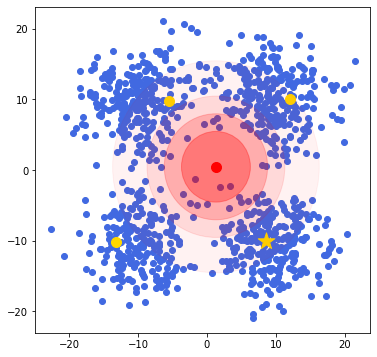

In [240]:
plt.figure(figsize=(6,6))

temp_R = 5
cir1 = plt.Circle(center, temp_R, color='r', alpha=0.3)
cir2 = plt.Circle(center, temp_R*1.5, color='r', alpha=0.2)
cir3 = plt.Circle(center, temp_R*2, color='r', alpha=0.1)
cir4 = plt.Circle(center, temp_R*3, color='r', alpha=0.05)
# ax.add_patch(cir)
plt.gca().add_patch(cir1)
plt.gca().add_patch(cir2)
plt.gca().add_patch(cir3)
plt.gca().add_patch(cir4)

plt.scatter(center[0], center[1], color='red', s=100)
plt.scatter(samples_np[:,0],samples_np[:,1], color='royalblue')
plt.scatter(protos[0,0], protos[0,1], color='gold', s=300, marker='*')
plt.scatter(protos[1:,0], protos[1:,1], color='gold', s=100)